In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Dataset Generator for MVLoR

In [12]:
class dataset_generator:
  def __init__(self, feature_dim, n_sample = 300, noise_factor = 0., direction = 1):
    self._feature_dim = feature_dim
    self._n_sample = n_sample
    self._noise_factor = noise_factor
    self._direction = direction

    self._init_feature_dict()
    self._init_t_th()


  def _init_feature_dict(self):
    self._feature_dict = dict()
    for feature_idx in range(1, self._feature_dim+1):
      x_dict = {'mean':0, 'std':1}
      self._feature_dict[feature_idx] = x_dict

  def _init_t_th(self):
    self._t_th = [0] + [1 for i in range(self._feature_dim)] # t_Th[0], t_Th[1] ... t_Th[m]


  def set_feature_dict(self, feature_dict):
    if len(feature_dict) != self._feature_dim:
      class FeatureDictError(Exception):
        pass
      raise FeatureDictError('The length of "feature_dict" should be equal to "feature_dim')
    else:
      self._feature_dict = feature_dict
 
  def set_t_th(self, t_th_list):
    if len(t_th_list) != len(self._t_th):
      class t_th_Error(Exception):
        pass
      raise t_th_Error('The length of "t_th_list" should be equal to "feature_dim + 1"')
    else:
      self._t_th = t_th_list

  def make_dataset(self):
    x_data = np.zeros(shape= (self._n_sample, 1)) # idx를 맞추기 위한 빈 껍데기
    y = np.zeros(shape=(self._n_sample, 1))

    for feature_idx in range(1, self._feature_dim+1):
      feature_dict = self._feature_dict[feature_idx]
      data = np.random.normal(loc = feature_dict['mean'], scale = feature_dict['std'],
                              size = (self._n_sample,1))
      x_data = np.hstack((x_data, data))
      y += self._t_th[feature_idx]*data # Th[1] * x1 ...
    y += self._t_th[0]
    y_noise = y + self._noise_factor*np.random.normal(0,1,(self._n_sample,1))

    if self._direction >0:
      y_data = (y_noise > 0).astype(np.int)
    else:
      y_data = (y_noise < 0).astype(np.int)

    data = np.hstack((x_data, y_data)) # 최종 데이터
    return data

# Dataset Visualizer

In [15]:
def dataset_visualizer():
  p_idx = np.where(data[:,-1] >0) # pass
  np_idx = np.where(data[:,-1] <=0) # non pass

  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(projection = '3d')

  ax.plot(data[p_idx,1].flat, data[p_idx,2].flat, data[p_idx,-1].flat, 'bo')
  ax.plot(data[np_idx,1].flat, data[np_idx,2].flat, data[np_idx,-1].flat, 'rX')

  ax.set_xlabel(r'$x_{1}$' + ' data', labelpad = 20)
  ax.set_ylabel(r'$x_{2}$' + ' data', labelpad = 20)
  ax.set_zlabel('y', labelpad= 20)

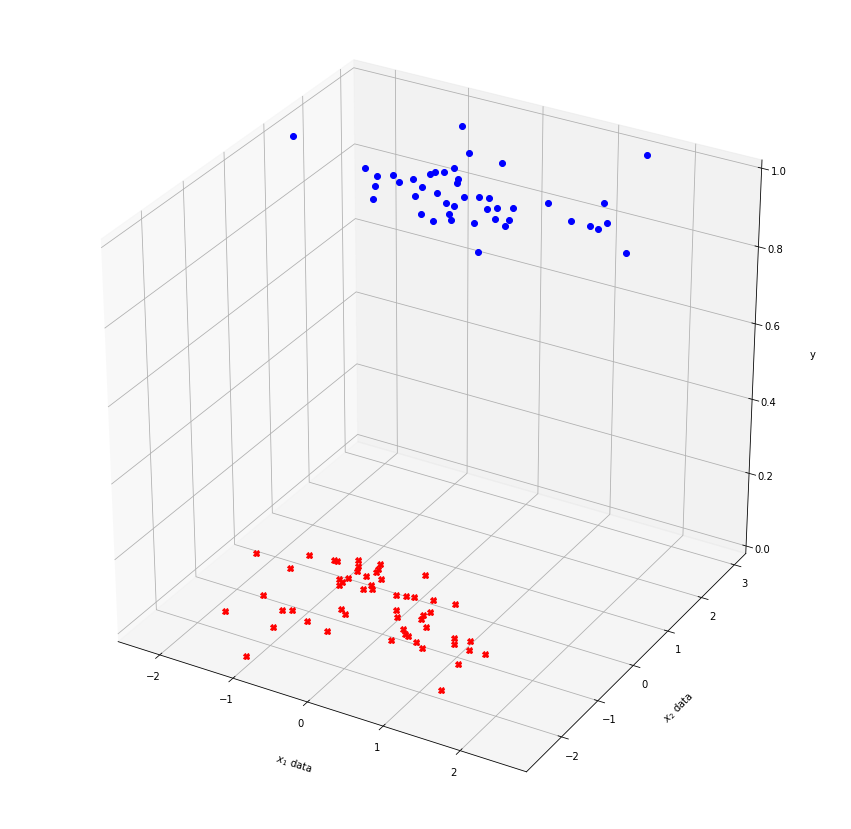

In [16]:
feature_dim = 2
noise_factor = 0.5
direction = 1
n_sample = 100

x_dict = {1:{'mean':0, 'std':1},
          2:{'mean':0, 'std':1}}
t_th_list = [0,1,2]

data_gen = dataset_generator(feature_dim= feature_dim,
                             n_sample = n_sample,
                             noise_factor = noise_factor,
                             direction= direction)

data_gen.set_t_th(t_th_list)
data_gen.set_feature_dict(x_dict)

data = data_gen.make_dataset()

dataset_visualizer()

# Basic nodes

In [23]:
# basic_nodes
class plus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None
      
  def forward(self,x,y):
    self._x, self._y = x, y
    self._z = self._x + self._y
    return self._z
  
  def backward(self, dz): # dz = dJ/dz
    return dz*1,dz*1 #dJ/dx= dJ/dz * dz/dx, dJ/dy

class minus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x, self._y = x, y
    self._z = self._x - self._y
    return self._z

  def backward(self, dz):
    return 1*dz, -1*dz

class mul_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x , self._y = x, y
    self._z = self._x * self._y
    return self._z

  def backward(self, dz):
    return dz*self._y, dz*self._x # dJ/dz * dz/dx, dJ/dy

class square_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = self._x * self._x
    return self._z

  def backward(self, dz):
    return dz*(2*self._x)

class mean_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = np.mean(self._x) # z = 1/n *(x1+x2+...+xn)
    return self._z

  def backward(self, dz):
    dx = dz*1/len(self._x)*np.ones_like(self._x) # dJ/dx1 = dJ/dz * dz/dx1 = dJ/dz * (1/n)
    return dx

# Affine Function

In [24]:
class Affine_Function:
    def __init__(self):
        self._feature_dim = feature_dim
        
        self._z1_list = [None]*(self._feature_dim + 1)
        self._z2_list = self._z1_list.copy()
        
        self._dz1_list, self._dz2_list = self._z1_list.copy(), self._z1_list.copy()
        self._dth_list = self._z1_list.copy()
        
        self.node_imp()
        self.random_initialization()
        
    def node_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]

    def random_initialization(self):
        r_feature_dim = 1/np.power(self._feature_dim, 0.5)
        self._Th = np.random.uniform(low = -1*r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx],
                                                                    X[node_idx])
        self._z2_list[1] = self._node2[1].forward(self._Th[0], self._z1_list[1])
        for node_idx in range(2, self._feature_dim + 1):
            self._z2_list[node_idx] = self._node2[node_idx].forward(self._z2_list[node_idx-1],
                                                                    self._z1_list[node_idx])
        return self._z2_list[-1]
    
    def backward(self, dz2_last, lr):
        self._dz2_list[-1] = dz2_last
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dz2, dz1 = self._node2[node_idx].backward(self._dz2_list[node_idx])
            self._dz2_list[node_idx-1] = dz2
            self._dz1_list[node_idx] = dz1
        
        self._dth_list[0] = self._dz2_list[0]
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dth, _ = self._node1[node_idx].backward(self._dz1_list[node_idx])
            self._dth_list[node_idx] = dth
        
        self._Th = self._Th - lr*np.array(self._dth_list).reshape(-1, 1)
        return self._Th

    def get_Th(self):
        return self._Th

# Sigmoid

In [18]:
class Sigmoid:
    def __init__(self):
        self._pred = None

    def forward(self, z):
        self._pred = 1/(1 + np.exp(-1*z))
        return self._pred
    
    def backward(self, dpred):
        partial = self._pred * (1 - self._pred)
        dz = dpred * partial
        return dz

# Bincary Cross Entropy Loss

In [19]:
class BinaryCrossEntropy_Loss:
    def __init__(self):
        self._y, self._pred = None, None

    def forward(self, y, pred):
        self._y, self._pred = y, pred
        loss = -1 * (y * np.log(self._pred) + (1 - y)*np.log(1 - pred))
        return loss

    def backward(self):
        dpred = (self._pred - self._y)/(self._pred * (1 - self._pred))
        return dpred

# Uility Function

In [20]:
def result_tracker():
    global iter_idx, check_freq
    global th_accum, affine
    
    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, affine.get_Th()))
        loss_list.append(1)
    iter_idx += 1


def plot_classifier():
    p_idx = np.where(data[:,-1] > 0)
    np_idx = np.where(data[:,-1] <= 0)
    
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(projection = '3d')
    
    ax.plot(data[p_idx, 1].flat, data[p_idx,2].flat, data[p_idx, -1].flat, 'bo')
    ax.plot(data[np_idx, 1].flat, data[np_idx,2].flat, data[np_idx, -1].flat, 'rX')
    
    ax.set_xlabel(r'$x_{1}$' + ' data', labelpad = 20)
    ax.set_ylabel(r'$x_{2}$' + ' data', labelpad = 20)
    ax.set_zlabel('y', labelpad = 20)
    
    f_th0, f_th1, f_th2 = th_accum[:,-1]
    x1_range = np.linspace(np.min(data[:, 1]), np.max(data[:,1]), 100)
    x2_range = np.linspace(np.min(data[:, 2]), np.max(data[:,2]), 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    affine = X2*f_th2 + X1*f_th1 + f_th0
    pred = sigmoid.forward(affine)
    
    ax.plot_wireframe(X1, X2, pred)
    

def result_visualizer():
    global th_accum, loss_list
    
    fig, ax = plt.subplots(figsize = (30, 10))
    fig.subplots_adjust(hspace = 0.3)
    ax.set_title(r'$\vec{\theta}$' + ' Update')
    
    for feature_idx in range(feature_dim + 1):
        
        ax.plot(th_accum[feature_idx, :], label = r'$\theta_{%d}$'%feature_idx)
        
    ax.legend()
    iter_ticks = np.linspace(0, th_accum.shape[1],10).astype(np.int)
    ax.set_xticks(iter_ticks)

# Learning

In [27]:
feature_dim = 2
noise_factor = 0.5
direction = 1
n_sample = 100

x_dict = {1:{'mean':0, 'std':1},
          2:{'mean':0, 'std':1}}
t_th_list = [0,1,2]

epochs, lr = 100, 0.01
iter_idx, check_freq = 0, 1

data_gen = dataset_generator(feature_dim= feature_dim,
                             n_sample = n_sample,
                             noise_factor = noise_factor,
                             direction= direction)

data_gen.set_t_th(t_th_list)
data_gen.set_feature_dict(x_dict)

data = data_gen.make_dataset()

In [28]:
affine = Affine_Function()
sigmoid = Sigmoid()
BCE_loss = BinaryCrossEntropy_Loss()

loss_list = []
th_accum = affine.get_Th()

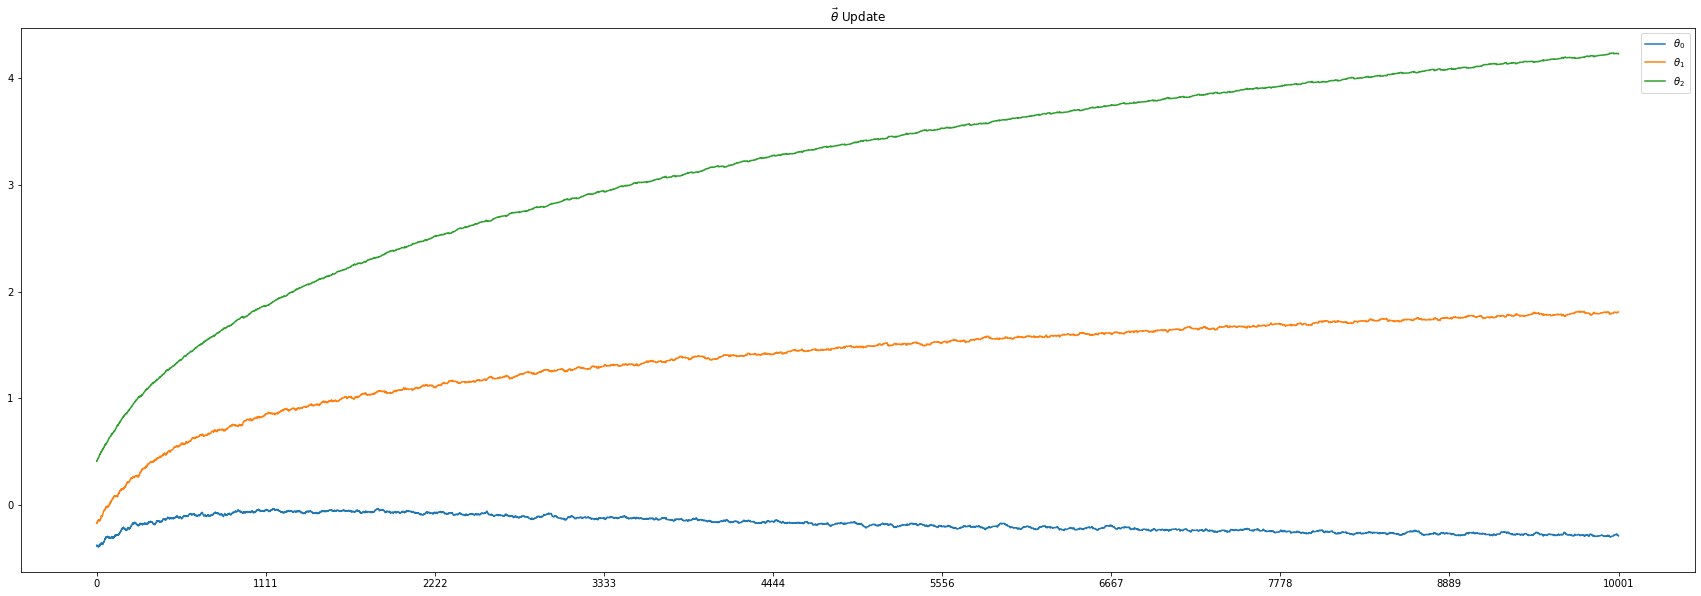

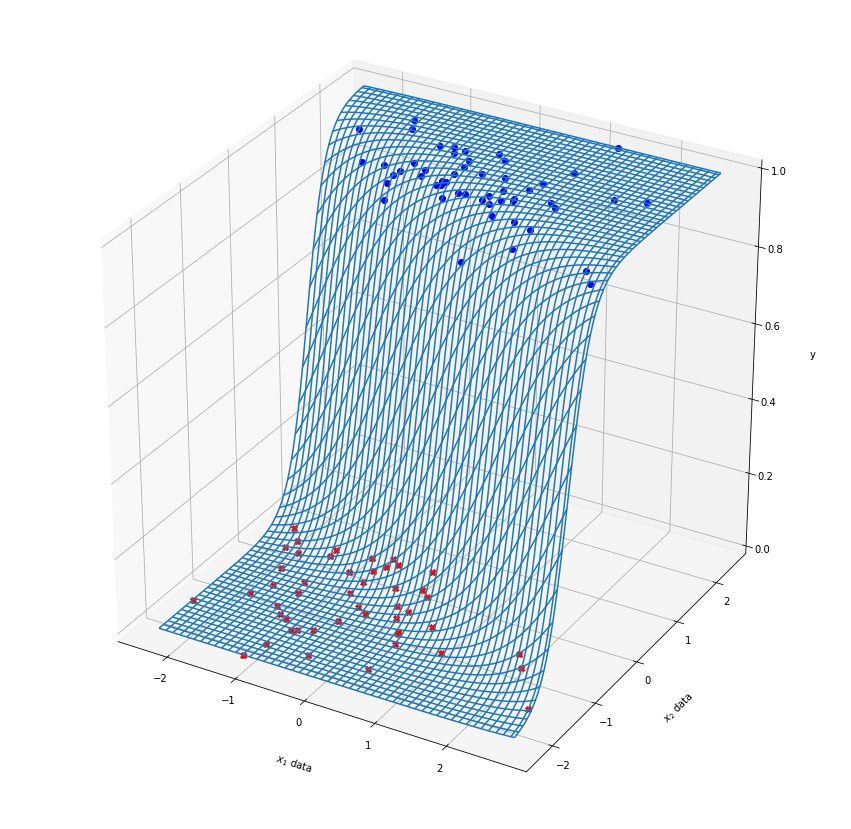

In [29]:
for epoch in range(epochs):
    np.random.shuffle(data)
    
    for data_idx in range(data.shape[0]):
        x, y =data[data_idx,:-1], data[data_idx, -1]
        
        z = affine.forward(x)
        pred = sigmoid.forward(z)
        l = BCE_loss.forward(y, pred)
        
        dpred = BCE_loss.backward()
        dz = sigmoid.backward(dpred)
        affine.backward(dz, lr)
        
        result_tracker()
        
result_visualizer()
plot_classifier()

# MVLoR Module

In [32]:
class MVLoR:
  def __init__(self):
    self._feature_dim = feature_dim

    self._affine = Affine_Function()
    self._sigmoid = Sigmoid()

  def forward(self, x):
    z = self._affine.forward(x)
    pred = self._sigmoid.forward(z)
    return pred

  def backward(self, dpred, lr):
    dz = self._sigmoid.backward(dpred)
    self._affine.backward(dz, lr)

  def get_Th(self):
    return self._affine.get_Th()

In [ ]:
model = MVLoR()
BCE_loss = BinaryCrossEntropy_Loss()

loss_list = []
th_accum = model.get_Th()

for epoch in range(epochs):
  np.random.shuffle(data)

  for data_idx in range(data.shape[0]):
    x, y = data[data_idx, :-1], data[data_idx, -1]

    pred = model.forward(x)
    l = BCE_loss.forward(y, pred)

    dpred = BCE_loss.backward()
    model.backward(dpred, lr)

    result_tracker()

result_visualizer()
plot_classifier()